# Data Import

In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic

In [2]:
# Set the run_code to test | run
run_code = 'run'

if run_code == 'run':
    dataset_path = '/kaggle/input/sncb-eda-data-clean/cleaned_ar41_for_ulb.csv'
else:
    dataset_path = '/kaggle/input/sncb-data-augumentation/enriched_cleaned_ar41_for_ulb.csv'

# Check if the file exists before trying to read it
if os.path.exists(dataset_path):
    data = pd.read_csv(dataset_path)

    # Display the basic information and the first few rows of the dataframe
    data_info = data.info()
    data_head = data.head()

    # If you want to print the information to the console
    print(data_info)
    print(data_head)
else:
    print(f"The file {dataset_path} does not exist.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17677337 entries, 0 to 17677336
Data columns (total 18 columns):
 #   Column              Dtype  
---  ------              -----  
 0   timestamps_UTC      object 
 1   mapped_veh_id       float64
 2   lat                 float64
 3   lon                 float64
 4   RS_E_InAirTemp_PC1  float64
 5   RS_E_InAirTemp_PC2  float64
 6   RS_E_OilPress_PC1   float64
 7   RS_E_OilPress_PC2   float64
 8   RS_E_RPM_PC1        float64
 9   RS_E_RPM_PC2        float64
 10  RS_E_WatTemp_PC1    float64
 11  RS_E_WatTemp_PC2    float64
 12  RS_T_OilTemp_PC1    float64
 13  RS_T_OilTemp_PC2    float64
 14  date                object 
 15  hour                float64
 16  dayofweek           float64
 17  weekday             object 
dtypes: float64(15), object(3)
memory usage: 2.4+ GB
None
        timestamps_UTC  mapped_veh_id        lat       lon  \
0  2023-01-23 07:25:08          102.0  51.017864  3.769079   
1  2023-01-23 07:25:16          102.0  51.0

In [3]:
data['lat'] = data['lat'].astype('float32')
data['lon'] = data['lon'].astype('float32')

# Speed Calculate

In [4]:
# if run_code == 'run':
#     # Convert timestamps to datetime format
#     data['timestamps_UTC'] = pd.to_datetime(data['timestamps_UTC'])

#     # Vectorize the distance calculation
#     def calculate_distances(lats, lons):
#         distances = np.zeros(len(lats))
#         for i in range(1, len(lats)):
#             if not np.isnan(lats[i]) and not np.isnan(lons[i]):
#                 distances[i] = geodesic((lats[i-1], lons[i-1]), (lats[i], lons[i])).kilometers
#         return distances

#     # Calculate distances using the vectorized function
#     latitudes = data['lat'].to_numpy()
#     longitudes = data['lon'].to_numpy()
#     data['Distance'] = calculate_distances(latitudes, longitudes)

#     # Calculate time intervals in hours
#     time_diffs = data['timestamps_UTC'].diff().dt.total_seconds() / 3600
#     time_diffs[0] = np.nan  # first element will be NaT after diff

#     # Calculate speeds in km/h
#     data['Speed'] = data['Distance'] / time_diffs

#     # Replace infinite values with NaN if division by zero occurred
#     data['Speed'].replace([np.inf, -np.inf], np.nan, inplace=True)

#     # Print the results
#     print(data[['timestamps_UTC', 'lat', 'lon', 'Distance', 'Speed']])
# else:
#     pass


In [5]:
# # Set 'Speed' to 0 where 'Speed' is greater than 120
# data.loc[data['Speed'] > 120, 'Speed'] = 0

In [6]:
data['timestamps_UTC'] = pd.to_datetime(data['timestamps_UTC'])

# # Moving Average to smooth data
# window_size = 5  
# data['lat_smooth'] = data['lat'].rolling(window=window_size).median()
# data['lon_smooth'] = data['lon'].rolling(window=window_size).median()

# Distance and Speed calculate function
def calculate_distances_and_speeds(data, min_interval=30):
    distances = np.zeros(len(data))
    speeds = np.zeros(len(data))
    previous_time = data['timestamps_UTC'].iloc[0]

    for i in range(1, len(data)):
        current_time = data['timestamps_UTC'].iloc[i]
        time_diff = (current_time - previous_time).total_seconds() / 3600  # change seconds to hours

        if time_diff >= min_interval / 3600:  # only when the interval larger than 30 seconds, we calculate the speed
            distance = geodesic((data['lat'].iloc[i-1], data['lon'].iloc[i-1]), 
                                (data['lat'].iloc[i], data['lon'].iloc[i])).kilometers
            speed = distance / time_diff if time_diff > 0 else 0
            distances[i] = distance
            speeds[i] = speed
            previous_time = current_time

    return distances, speeds

data['Distance'], data['Speed'] = calculate_distances_and_speeds(data)

In [7]:
# Handing outliers
speed_threshold = 120  # 120 km/h
data.loc[data['Speed'] > speed_threshold, 'Speed'] = np.nan

Interpelate

In [8]:
# Interpelate 
# Replace 0 with NaN in the whole dataset
data.replace(0, np.nan, inplace=True)

# Convert 'timestamps_UTC' to datetime, if not already done
data['timestamps_UTC'] = pd.to_datetime(data['timestamps_UTC'])

# Set 'timestamps_UTC' as the index
data.set_index('timestamps_UTC', inplace=True)

# Check for NaN values in the index
if data.index.hasnans:
    raise ValueError("The index contains NaNs, which cannot be present for time interpolation.")

# Interpolate the NaN values in the whole dataset
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
data[numeric_cols] = data[numeric_cols].interpolate(method='time')

In [9]:
# Replace 0 with NaN in the whole dataset
data.replace(np.nan, 0, inplace=True)

# result
print(data[['lat', 'lon', 'Distance', 'Speed']])

                           lat       lon  Distance      Speed
timestamps_UTC                                               
2023-01-23 07:25:08  51.017864  3.769078  0.000000   0.000000
2023-01-23 07:25:16  51.017876  3.769046  0.000000   0.000000
2023-01-23 07:25:37  51.017208  3.770179  0.000000   0.000000
2023-01-23 07:25:41  51.016914  3.771036  0.068434   7.465564
2023-01-23 07:26:10  51.016502  3.772182  0.052601   6.287259
...                        ...       ...       ...        ...
2023-09-13 17:33:03  50.402695  4.450110  0.030669   1.811908
2023-09-13 17:33:58  50.401657  4.452693  0.211409  12.899178
2023-09-13 17:34:03  50.401829  4.452218  0.232337  14.176355
2023-09-13 17:34:58  50.401058  4.455389  0.207086  12.017265
2023-09-13 17:35:04  50.401085  4.455169  0.202145  11.643050

[17677337 rows x 4 columns]


In [10]:
# Change data type to reduce the data size
data['Distance'] = data['Distance'].astype('float32')
data['Speed'] = data['Speed'].astype('float32')

# Distribution of Distance

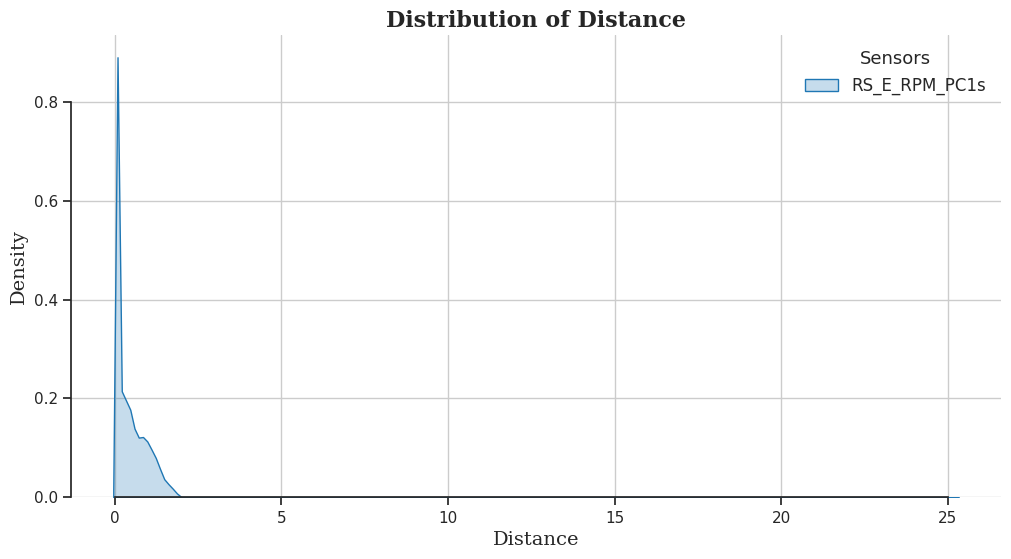

In [11]:
# Setting the overall aesthetics for the plot to have an academic look
sns.set_theme(style='ticks', palette='muted')

# Initialize the matplotlib figure
plt.figure(figsize=(12, 6))

# Plotting the Kernel Density Estimate (KDE) plot for RS_E_RPM_PC1
sns.kdeplot(data['Distance'], fill=True, color="#1f77b4", label='RS_E_RPM_PC1s', bw_adjust=0.5)


# Adding titles and labels with a formal font type
plt.title('Distribution of Distance', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Distance', fontsize=14, family='serif')
plt.ylabel('Density', fontsize=14, family='serif')

# Adding gridlines and removing the top and right axis lines for a cleaner look
sns.despine(trim=True)
plt.grid(True)

# Adjusting the legend to be more formal
plt.legend(title='Sensors', title_fontsize='13', fontsize='12', frameon=False)

# Show the plot with the improved academic aesthetics
plt.show()

# Distribution of Speed

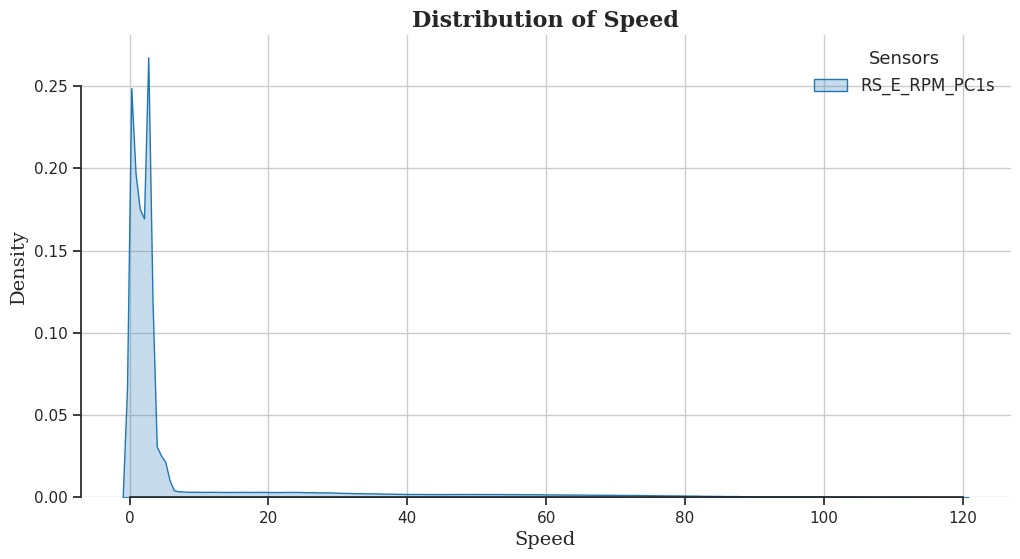

In [12]:
# Setting the overall aesthetics for the plot to have an academic look
sns.set_theme(style='ticks', palette='muted')

# Initialize the matplotlib figure
plt.figure(figsize=(12, 6))

# Plotting the Kernel Density Estimate (KDE) plot for RS_E_RPM_PC1
sns.kdeplot(data['Speed'], fill=True, color="#1f77b4", label='RS_E_RPM_PC1s', bw_adjust=0.5)


# Adding titles and labels with a formal font type
plt.title('Distribution of Speed', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Speed', fontsize=14, family='serif')
plt.ylabel('Density', fontsize=14, family='serif')

# Adding gridlines and removing the top and right axis lines for a cleaner look
sns.despine(trim=True)
plt.grid(True)

# Adjusting the legend to be more formal
plt.legend(title='Sensors', title_fontsize='13', fontsize='12', frameon=False)

# Show the plot with the improved academic aesthetics
plt.show()

In [13]:
# get the column timestamps_UTC from index
data = data.reset_index()

# Weather Data

In [14]:
dataset_path = '/kaggle/input/weather-data-7d/WeatherData.csv'

# Check if the file exists before trying to read it
if os.path.exists(dataset_path):
    weather_data = pd.read_csv(dataset_path)

    # Display the basic information and the first few rows of the dataframe
    data_info = weather_data.info()
    data_head = weather_data.head()

    # If you want to print the information to the console
    print(data_info)
    print(data_head)
else:
    print(f"The file {dataset_path} does not exist.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10086452 entries, 0 to 10086451
Data columns (total 10 columns):
 #   Column        Dtype  
---  ------        -----  
 0   datetime      object 
 1   lat           float64
 2   lon           float64
 3   weather_main  object 
 4   temp          float64
 5   feels_like    float64
 6   pressure      int64  
 7   humidity      int64  
 8   wind          float64
 9   clouds        int64  
dtypes: float64(5), int64(3), object(2)
memory usage: 769.5+ MB
None
              datetime    lat   lon weather_main    temp  feels_like  \
0  2023-01-01 00:00:00  50.77  3.87         Rain  287.81      286.85   
1  2023-01-01 01:00:00  50.77  3.87       Clouds  287.41      286.46   
2  2023-01-01 02:00:00  50.77  3.87         Rain  287.57      286.69   
3  2023-01-01 03:00:00  50.77  3.87       Clouds  287.22      286.46   
4  2023-01-01 04:00:00  50.77  3.87         Rain  286.40      285.74   

   pressure  humidity   wind  clouds  
0      1010        5

In [15]:
# Remove duplicate rows from the weather_data dataframe
weather_data = weather_data.drop_duplicates()

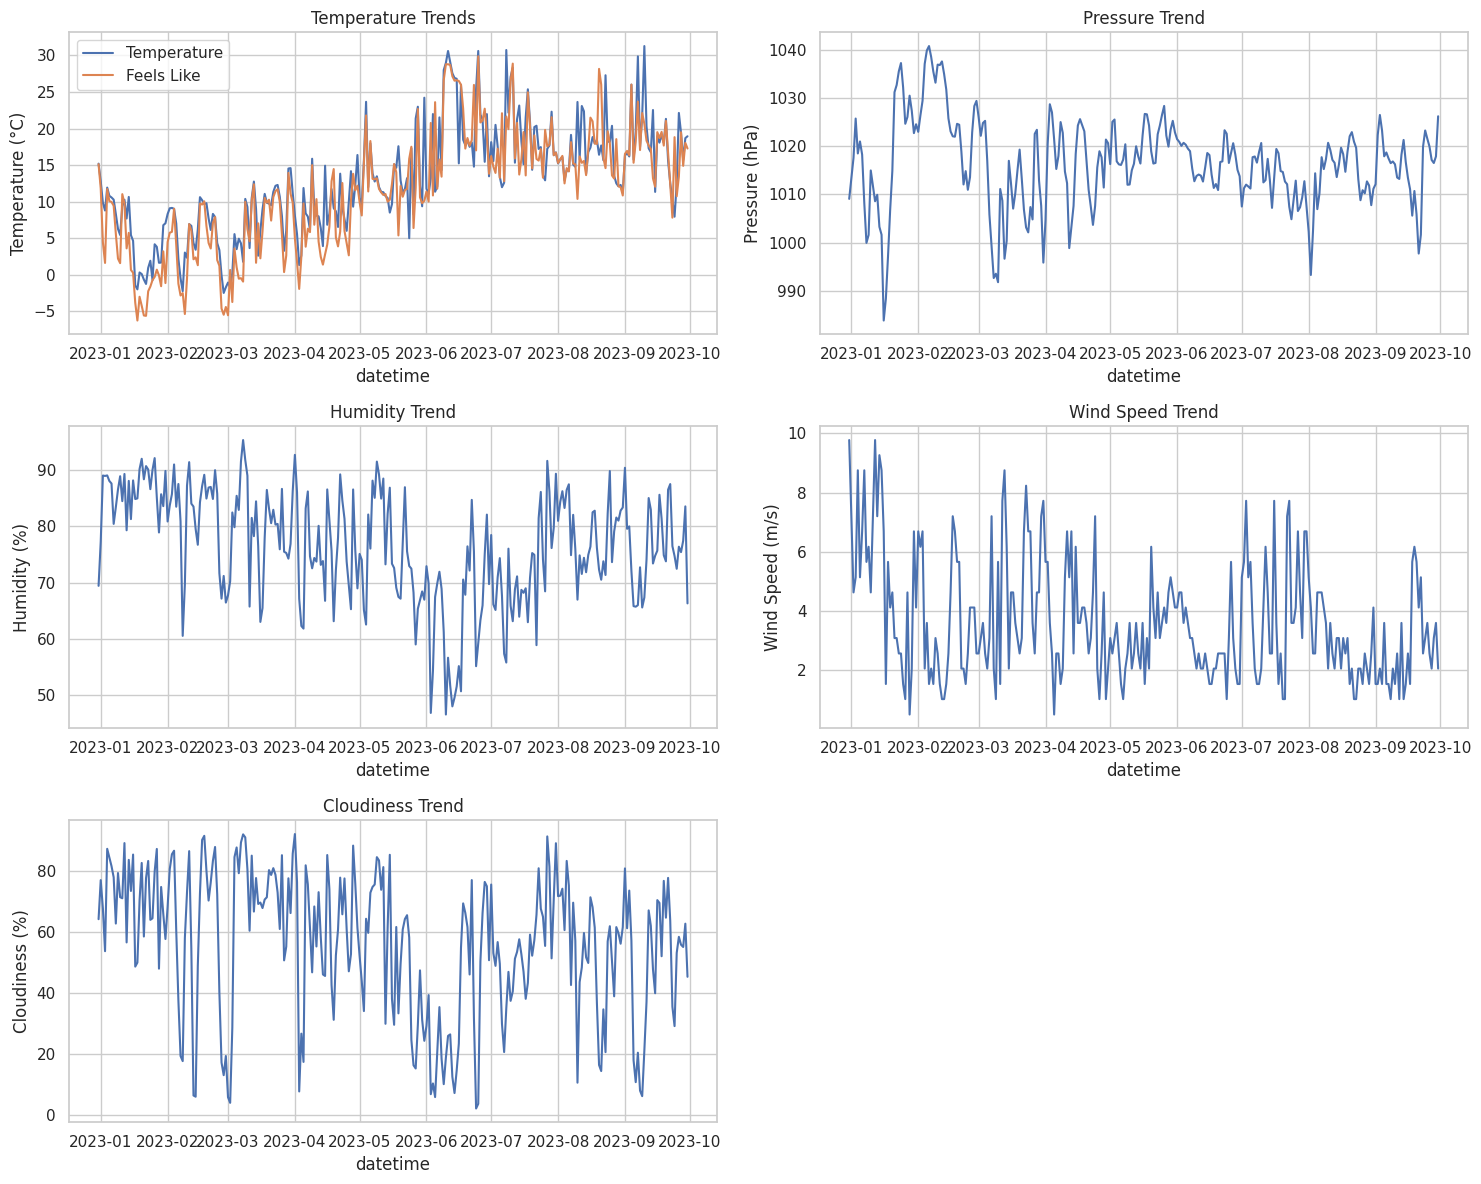

In [16]:
# Convert weather data from K to Celsius
weather_data['temp_celsius'] = weather_data['temp'] - 273.15
weather_data['feels_like_celsius'] = weather_data['feels_like'] - 273.15

# Convert 'datetime' to a datetime object
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])

# Convert data types to reduce memory usage
for col in weather_data.select_dtypes(include=['float64']).columns:
    weather_data[col] = weather_data[col].astype('float32')

# Separate numeric and non-numeric columns
numeric_cols = weather_data.select_dtypes(include=['float64', 'int64']).columns
non_numeric_cols = weather_data.select_dtypes(exclude=['float64', 'int64', 'datetime']).columns

# Resample numeric data to daily averages
daily_weather_data_numeric = weather_data.set_index('datetime')[numeric_cols].resample('D').mean()

# For non-numeric data, choose another aggregation method
daily_weather_data_non_numeric = weather_data.set_index('datetime')[non_numeric_cols].resample('D').agg(lambda x: x.mode()[0])

# Merge the resampled data back together
daily_weather_data = pd.merge(daily_weather_data_numeric, daily_weather_data_non_numeric, left_index=True, right_index=True)

# Set a style for the plots
sns.set(style="whitegrid")

# Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

# Temperature trends
# sns.lineplot(x=daily_weather_data.index, y='temp', data=daily_weather_data, ax=axes[0, 0])
# sns.lineplot(x=daily_weather_data.index, y='feels_like', data=daily_weather_data, ax=axes[0, 0])
# axes[0, 0].set_title('Temperature Trends')
# axes[0, 0].set_ylabel('Temperature (K)')
# axes[0, 0].legend(['Temperature', 'Feels Like'])

# Temperature trends
sns.lineplot(x=daily_weather_data.index, y='temp_celsius', data=daily_weather_data, ax=axes[0, 0], label='Temperature')
sns.lineplot(x=daily_weather_data.index, y='feels_like_celsius', data=daily_weather_data, ax=axes[0, 0], label='Feels Like')
axes[0, 0].set_title('Temperature Trends')
axes[0, 0].set_ylabel('Temperature (°C)')
axes[0, 0].legend()

# Pressure trend
sns.lineplot(x=daily_weather_data.index, y='pressure', data=daily_weather_data, ax=axes[0, 1])
axes[0, 1].set_title('Pressure Trend')
axes[0, 1].set_ylabel('Pressure (hPa)')

# Humidity trend
sns.lineplot(x=daily_weather_data.index, y='humidity', data=daily_weather_data, ax=axes[1, 0])
axes[1, 0].set_title('Humidity Trend')
axes[1, 0].set_ylabel('Humidity (%)')

# Wind speed trend
sns.lineplot(x=daily_weather_data.index, y='wind', data=daily_weather_data, ax=axes[1, 1])
axes[1, 1].set_title('Wind Speed Trend')
axes[1, 1].set_ylabel('Wind Speed (m/s)')

# Cloudiness trend
sns.lineplot(x=daily_weather_data.index, y='clouds', data=daily_weather_data, ax=axes[2, 0])
axes[2, 0].set_title('Cloudiness Trend')
axes[2, 0].set_ylabel('Cloudiness (%)')

# Drop unused subplot
fig.delaxes(axes[2][1])

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [17]:
# Basic statistics for each column
basic_statistics = daily_weather_data.describe()

basic_statistics

,pressure,humidity,clouds,lat,lon,temp,feels_like,wind,temp_celsius,feels_like_celsius
count,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000
mean,1016.408005,76.575050,56.063326,51.010002,4.484707,285.996704,284.628906,3.638722,12.846715,11.478905
std,9.180004,9.956466,23.304816,0.000000,0.209323,7.307384,8.109566,1.986347,7.307384,8.109566
min,983.823879,46.491160,2.149577,51.009998,4.390000,270.679993,266.910004,0.510000,-2.470000,-6.240000
25%,1011.483804,69.753495,41.112014,51.009998,4.400000,281.300011,278.799995,2.060000,8.150000,5.650000
50%,1016.789199,76.398432,60.665028,51.009998,4.400000,285.445007,285.009995,3.090000,12.295000,11.860000
75%,1022.147057,84.944894,74.742876,51.009998,4.400000,290.722511,290.324997,4.630000,17.572500,17.175000
max,1040.800872,95.389654,92.253509,51.009998,4.990000,304.420013,303.019989,9.770000,31.270000,29.870001


# Merge Data

In [18]:
# Convert the timestamp columns to datetime objects and round lat/lon to two decimal places in both datasets
data['timestamps_UTC'] = pd.to_datetime(data['timestamps_UTC'])
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])

data['lat'] = data['lat'].round(2)
data['lon'] = data['lon'].round(2)
weather_data['lat'] = weather_data['lat'].round(2)
weather_data['lon'] = weather_data['lon'].round(2)

# Add a new column to both datasets for merging: date and hour (rounded to the nearest hour)
data['date_hour'] = data['timestamps_UTC'].dt.round('H')
weather_data['date_hour'] = weather_data['datetime'].dt.round('H')

# Merge the datasets on the new date_hour, lat, and lon columns
merged_data = pd.merge(data, weather_data, how='left', on=['date_hour', 'lat', 'lon'])
merged_data.head()

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,...,datetime,weather_main,temp,feels_like,pressure,humidity,wind,clouds,temp_celsius,feels_like_celsius
0,2023-01-23 07:25:08,102.0,51.02,3.77,17.0,18.0,210.0,210.0,858.0,839.0,...,2023-01-23 07:00:00,Clouds,274.540009,271.75,1035.0,92.0,2.52,100.0,1.39,-1.4
1,2023-01-23 07:25:16,102.0,51.02,3.77,17.0,20.0,200.0,200.0,801.0,804.0,...,2023-01-23 07:00:00,Clouds,274.540009,271.75,1035.0,92.0,2.52,100.0,1.39,-1.4
2,2023-01-23 07:25:37,102.0,51.02,3.77,19.0,20.0,193.0,207.0,803.0,808.0,...,2023-01-23 07:00:00,Clouds,274.540009,271.75,1035.0,92.0,2.52,100.0,1.39,-1.4
3,2023-01-23 07:25:41,102.0,51.02,3.77,19.0,20.0,196.0,203.0,801.0,803.0,...,2023-01-23 07:00:00,Clouds,274.540009,271.75,1035.0,92.0,2.52,100.0,1.39,-1.4
4,2023-01-23 07:26:10,102.0,51.02,3.77,19.0,21.0,200.0,203.0,795.0,807.0,...,2023-01-23 07:00:00,Clouds,274.540009,271.75,1035.0,92.0,2.52,100.0,1.39,-1.4


In [19]:
merged_data[merged_data['temp'].notnull()]

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,...,datetime,weather_main,temp,feels_like,pressure,humidity,wind,clouds,temp_celsius,feels_like_celsius
0,2023-01-23 07:25:08,102.0,51.020000,3.77,17.0,18.0,210.0,210.0,858.0,839.0,...,2023-01-23 07:00:00,Clouds,274.540009,271.750000,1035.0,92.0,2.52,100.0,1.39,-1.40
1,2023-01-23 07:25:16,102.0,51.020000,3.77,17.0,20.0,200.0,200.0,801.0,804.0,...,2023-01-23 07:00:00,Clouds,274.540009,271.750000,1035.0,92.0,2.52,100.0,1.39,-1.40
2,2023-01-23 07:25:37,102.0,51.020000,3.77,19.0,20.0,193.0,207.0,803.0,808.0,...,2023-01-23 07:00:00,Clouds,274.540009,271.750000,1035.0,92.0,2.52,100.0,1.39,-1.40
3,2023-01-23 07:25:41,102.0,51.020000,3.77,19.0,20.0,196.0,203.0,801.0,803.0,...,2023-01-23 07:00:00,Clouds,274.540009,271.750000,1035.0,92.0,2.52,100.0,1.39,-1.40
4,2023-01-23 07:26:10,102.0,51.020000,3.77,19.0,21.0,200.0,203.0,795.0,807.0,...,2023-01-23 07:00:00,Clouds,274.540009,271.750000,1035.0,92.0,2.52,100.0,1.39,-1.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17677332,2023-09-13 17:33:03,197.0,50.400002,4.45,37.0,40.0,220.0,258.0,803.0,803.0,...,2023-09-13 18:00:00,Clouds,290.380005,290.220001,1021.0,79.0,3.60,20.0,17.23,17.07
17677333,2023-09-13 17:33:58,197.0,50.400002,4.45,37.0,38.0,224.0,307.0,843.0,941.0,...,2023-09-13 18:00:00,Clouds,290.380005,290.220001,1021.0,79.0,3.60,20.0,17.23,17.07
17677334,2023-09-13 17:34:03,197.0,50.400002,4.45,37.0,38.0,224.0,307.0,841.0,932.0,...,2023-09-13 18:00:00,Clouds,290.380005,290.220001,1021.0,79.0,3.60,20.0,17.23,17.07
17677335,2023-09-13 17:34:58,197.0,50.400002,4.46,36.0,38.0,207.0,244.0,800.0,803.0,...,2023-09-13 18:00:00,Clouds,290.380005,290.220001,1021.0,79.0,3.60,20.0,17.23,17.07


# Save to CSV

In [20]:
merged_data.to_csv('enriched_cleaned_ar41_for_ulb.csv', index=True)